# DS3000 lecture 22

### Admin:
- Second to the last lecture
- Quiz 3 for the weekend

### Content:
- PCA

In [21]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

## Principal Component Analysis

### More than just dimension reduction

PCA takes a collection of x-features and:
- Computes linear combinations of all x-features such that the correlations between the combinations (the principal components) are all zero
- Based on these components one can:
    - assess which features are strongly correlated and which are not
    - assess if there are certain clusters of observations that are revealed (these are less "formal" clusters than in K-means)
    - use the components for any distance based supervised learning algorithm (like K-NN or regression)

### PCA vs. Scale Normalization

Scale normalization prepares x-features for ML algorithms by putting all x-features on the same scale while preserving their correlations.

PCA both scale normalizes **and** then prepares x-features for ML algorithms by **removing** correlations between the x-features while preserving information about their relationships.

In [22]:
def make_lower(x):
    return str(x).lower()

df_poke = pd.read_csv('pokedata.csv')
df_poke = df_poke.rename(make_lower, axis = 1)
df_poke = df_poke.set_index('pokedex')
df_poke.head()

,pokemon,maintype,secondarytype,height,weight,damage,basespeed,attack,defense
pokedex,,,,,,,,,
1,Bulbasaur,Grass,Poison,24,25.2,45,45,49,49
2,Ivysaur,Grass,Poison,39,28.7,60,60,62,63
3,Venusaur,Grass,Poison,79,220.5,80,80,82,83
4,Charmander,Fire,NaN,24,18.7,39,65,52,43
5,Charmeleon,Fire,NaN,43,41.9,58,80,64,58


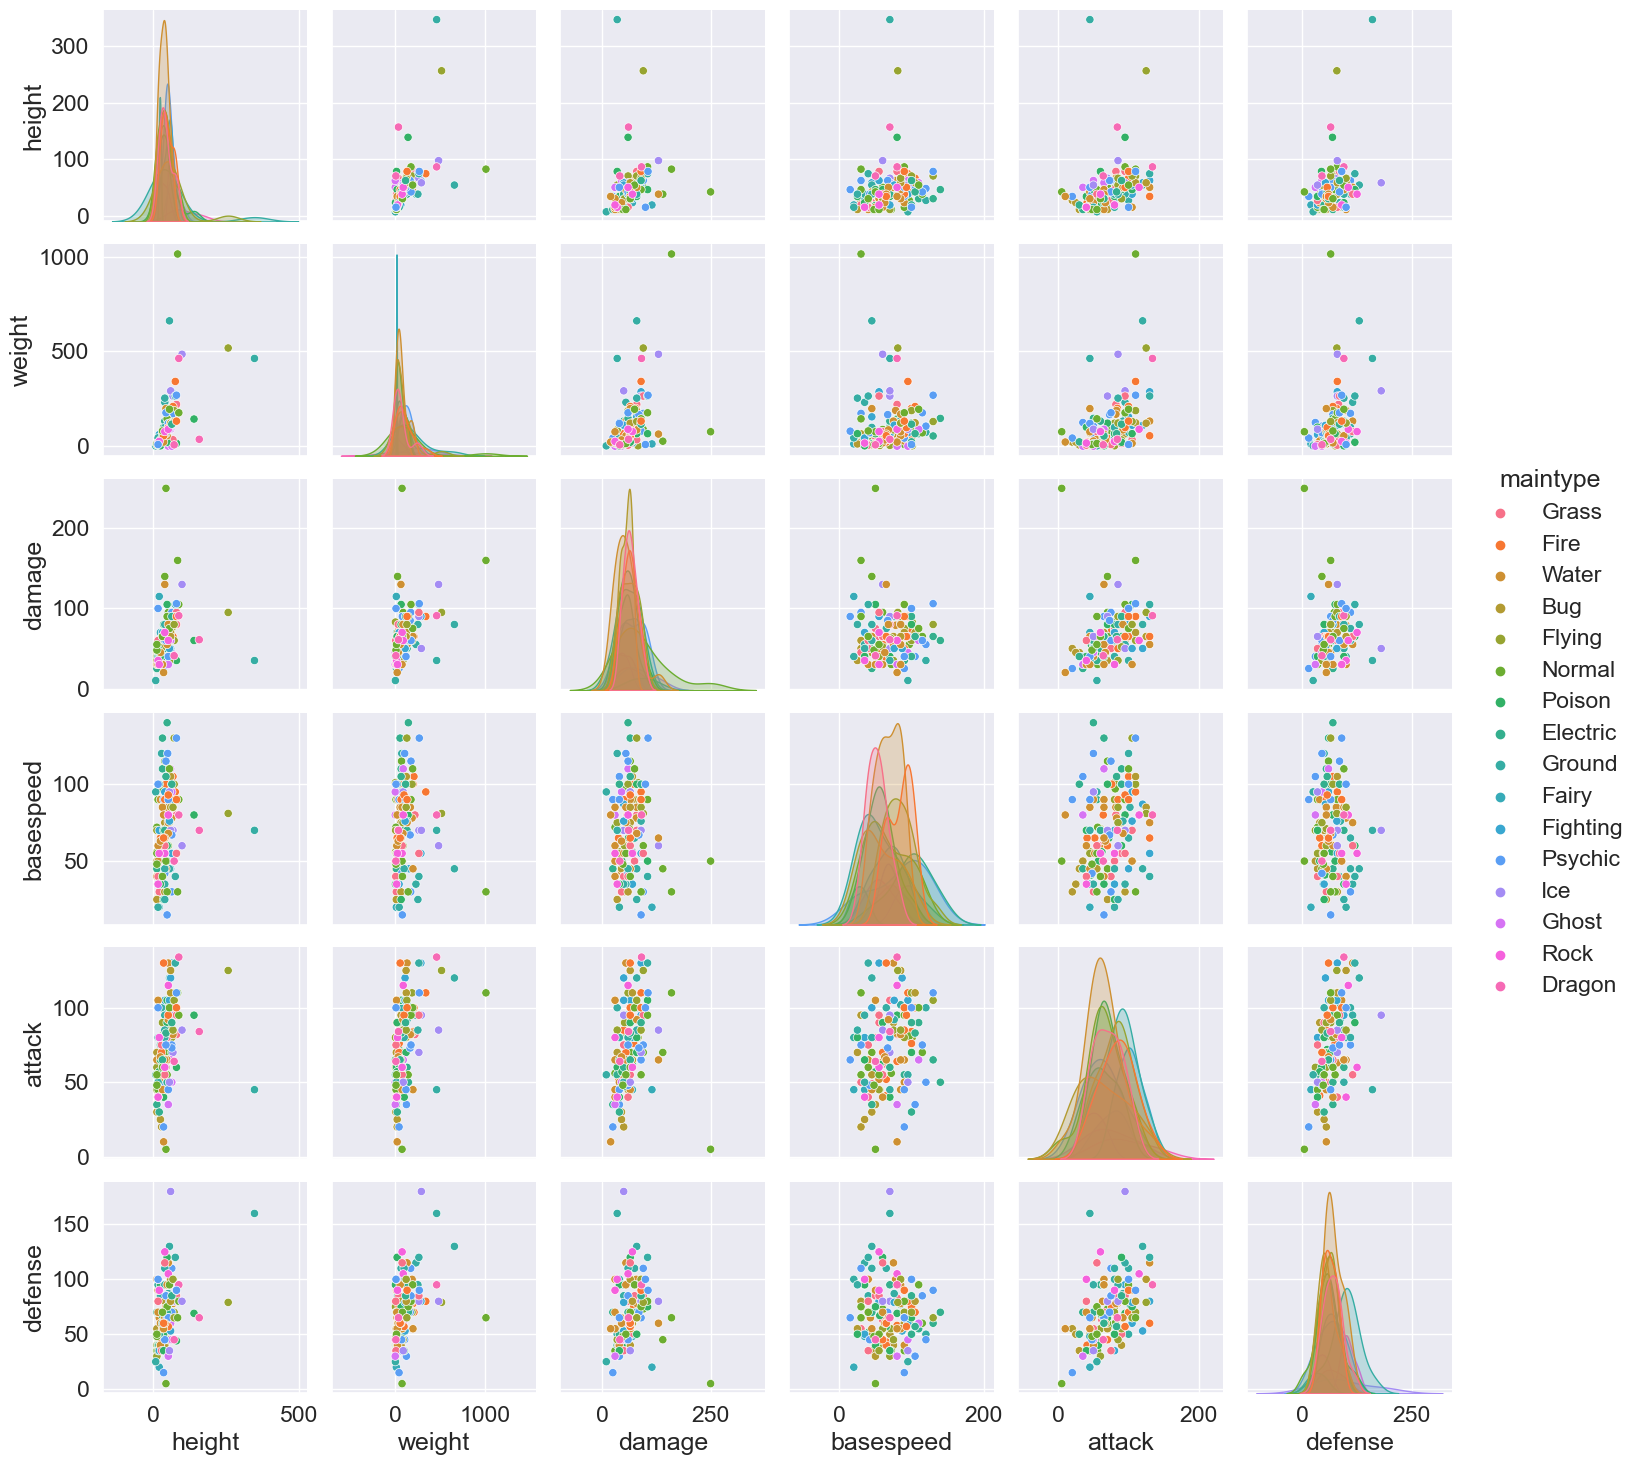

In [23]:
sns.set(font_scale=1.5)

sns.pairplot(df_poke, hue='maintype');

In [24]:
x_feat_list = df_poke.columns[3:]
df_poke0 = df_poke.loc[:,x_feat_list]

df_poke0.cov()

,height,weight,damage,basespeed,attack,defense
height,1434.948698,2812.923275,263.536645,202.599603,313.770817,366.510684
weight,2812.923275,17239.445888,1673.129204,185.234597,1605.373603,1452.893957
damage,263.536645,1673.129204,817.131921,-31.478764,226.885607,92.157130
basespeed,202.599603,185.234597,-31.478764,715.395585,144.560927,-38.338322
attack,313.770817,1605.373603,226.885607,144.560927,715.852539,347.606181
defense,366.510684,1452.893957,92.157130,-38.338322,347.606181,724.508962


In [27]:
from copy import copy

df_poke0_sn = copy(df_poke0)
for col in df_poke0_sn.columns:
    df_poke0_sn[col] = df_poke0_sn[col]/df_poke0_sn[col].std()

In [28]:
df_poke0_sn.cov()

,height,weight,damage,basespeed,attack,defense
height,1.000000,0.565559,0.243375,0.199962,0.309587,0.359457
weight,0.565559,1.000000,0.445781,0.052746,0.456986,0.411103
damage,0.243375,0.445781,1.000000,-0.041172,0.296653,0.119774
basespeed,0.199962,0.052746,-0.041172,1.000000,0.202007,-0.053252
attack,0.309587,0.456986,0.296653,0.202007,1.000000,0.482674
defense,0.359457,0.411103,0.119774,-0.053252,0.482674,1.000000


In [29]:
from sklearn.decomposition import PCA

pca = PCA(whiten = True)
x_pca = pca.fit_transform(df_poke0.values)

In [31]:
print(df_poke0.values.shape)
print(x_pca.shape)

(151, 6)
(151, 6)


In [34]:
np.cov(x_pca.T).round()

array([[ 1., -0., -0.,  0.,  0., -0.],
       [-0.,  1., -0., -0.,  0.,  0.],
       [-0., -0.,  1.,  0., -0., -0.],
       [ 0., -0.,  0.,  1., -0., -0.],
       [ 0.,  0., -0., -0.,  1.,  0.],
       [-0.,  0., -0., -0.,  0.,  1.]])

## No Free Lunch: PCA features are tough to interpret

PCA removes correlations in its output features by "mixing" input features by scaling and adding them together:
   
    pca0 = scale00 * height + scale01 * weight + scale02 * damage + scale03 * basespeed + scale04 * attack + scale05 * defense
    
Where `pca0` is the new first feature (column) of `x_pca` in the above example.  **One major downside to PCA is that this mixing precludes our simple understanding of what a feature means**.  

- Initially, the first feature was `height` of the Pokemon.
- After scale normalization, the first feature was some multiplier times `height` of the Pokemon.
- After PCA, the first feature is ... a bit more difficult to wrap your head around!

## What exactly is going on in PCA?

C:\Users\yangx\AppData\Local\Temp\ipykernel_16348\3344779273.py:10: RuntimeWarning:

covariance is not symmetric positive-semidefinite.



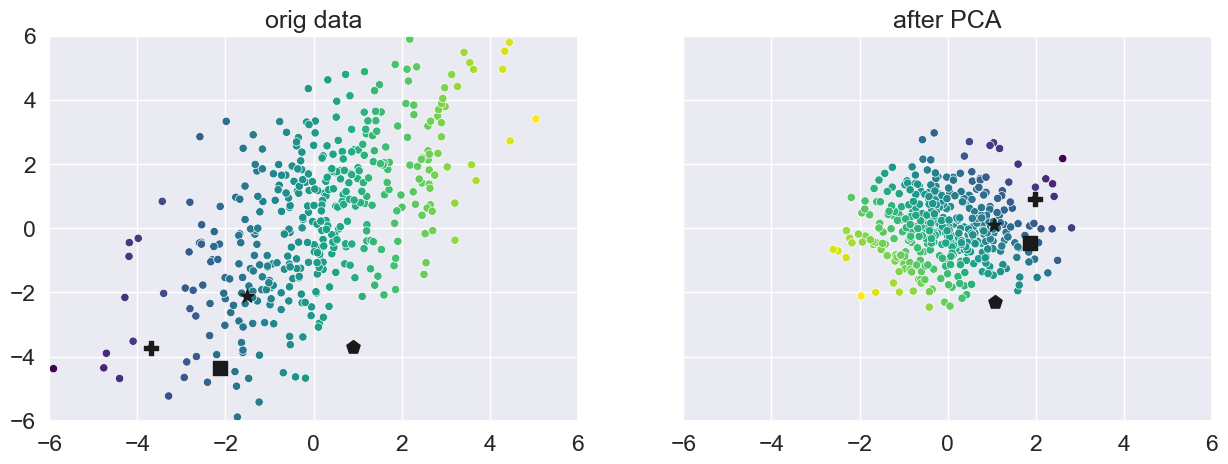

In [35]:
from sklearn.decomposition import PCA

n = 400
mean = np.array([0, 0])
cov = np.array([[1, 4],
                [4, 5]])


np.random.seed(0)
x = np.random.multivariate_normal(mean=mean, cov=cov, size=n)

# apply PCA
pca = PCA(whiten=True)
x_pca = pca.fit_transform(x)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

for _x, label, _ax in zip((x, x_pca),
                         ('orig data', 'after PCA'),
                         axs):
    # plot all data, we add "hue" proportional to original x0 feature
    # to allow viewers to track which points went where under PCA operation
    plt.sca(_ax)
    sns.scatterplot(x=_x[:, 0], y=_x[:, 1], hue=x[:, 0], palette='viridis')
    
    # plot first few points with special markers (again, to track which
    # points moved where under PCA)
    for idx, marker in enumerate('spP*'):
        plt.scatter(_x[idx, 0], _x[idx, 1], color='k', marker=marker, s=100)
        
    # groom plot
    plt.xlim((-6, 6))
    plt.ylim((-6, 6))
    _ax.get_legend().remove()
    _ax.set_title(label)

fig.set_size_inches(15, 5)

(Follow particular samples using the color / symbols above through the transformation)

Notice:
- the diagonal structure on left graph indicates features are correlated
- the circular structure on right graph indicates features are uncorrelated

PCA works by rotating and scaling the dataset around its center to remove correlations.

## So how, exactly, does PCA rotate / scale?

- PCA aligns the direction of maximum variance, orthogonal to *all previous directions (pink line in left plot) with the first axis in output (x axis)
- PCA aligns the direction of maximum variance, orthogonal to all previous directions (red line in left plot) with the second axis in output (y axis)

*there are no previous directions in the first step...

<img src="https://i.ibb.co/XLV2FQW/pca-rotate-axes.png" width=900px>


### In more mathematical terms:

- Step # 1: Zero-center the dataset

$$x_{new} = x - mean(x)$$

- Step # 2: Calculate the Covariance matrix ($\Sigma$) using the zero-centered dataset

**See correlation lecture for calculations**

- Step # 3: Calculate the Eigenvalues and Eigenvectors

    - (1) Solve $\Sigma - \lambda I = 0$ for $\lambda$ (the eigenvalues)
    - (2) Solve $\Sigma\nu = \lambda\nu$ for $\nu$ (the eigenvectors)

- Step # 4: Apply the Eigenvalues and Eigenvectors to the data

$$X_{pca} = \Lambda^{-1/2} U^T X_{new}$$

    - where $\Lambda$ is the matrix of eigenvalues, $U$ is the matrix of eigenvectors, and $X_{new}$ is the design matrix using the zero-centered x-features

PCA is looking to "capture" as much variance in the original data as it can with each new feature it adds.  This makes it an attractive dimensionality reduction method:

## Besides scale-normalization & removing correlations, what's PCA good for?

Suppose we had 10000 features to our samples, many ML methods would struggle with so many features.  We could apply PCA and only keep the first few `n_components` to try and "capture" as much variance in the original data.

### Motivating use cases:
- PCA "map" (or bi-plot)
    - use PCA to reduce dimensionality to two dimensions
    - scatter those two dimensions
    - similar samples should be close together (sort of clusters)
- Compression (eigen-mon)
    - how can we best represent a sample with 10000 features by using only a few?
    - our compressed version will misrepresent original sample a bit ...
    - ... but by using far fewer features it'll use less memory
    
        - storage
        - communication
        - analysis    

## PCA "map" / bi-plot
#### visualizing a 2d map of Pokemon 

- similar Pokemon close
- different Pokemon far

Our Pokemon dataset has several features ...

In [36]:
df_poke.head()

,pokemon,maintype,secondarytype,height,weight,damage,basespeed,attack,defense
pokedex,,,,,,,,,
1,Bulbasaur,Grass,Poison,24,25.2,45,45,49,49
2,Ivysaur,Grass,Poison,39,28.7,60,60,62,63
3,Venusaur,Grass,Poison,79,220.5,80,80,82,83
4,Charmander,Fire,NaN,24,18.7,39,65,52,43
5,Charmeleon,Fire,NaN,43,41.9,58,80,64,58


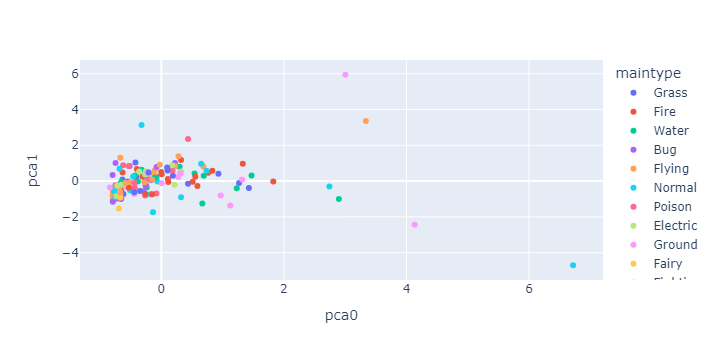

In [38]:
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(whiten = True, n_components = 2)
x_pca = pca.fit_transform(df_poke0.values)

df_poke['pca0'] = x_pca[:, 0]
df_poke['pca1'] = x_pca[:, 1]

fig = px.scatter(df_poke, x = 'pca0', y = 'pca1', hover_data = ['pokemon', 'maintype'], 
                 color = 'maintype')
fig.show()

In [ ]:
#pip install pca

In [39]:
# another module that conducts PCA (and plots a biplot)
from pca import pca

new_pca = pca(n_components = 2)
new_pca.fit_transform(df_poke0.values)

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [6] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


{'loadings':             1         2         3         4         5         6
 PC1  0.168641  0.972195  0.097896  0.012687  0.095472  0.086823
 PC2  0.808024 -0.181519 -0.100449  0.429022  0.239637  0.250144,
 'PC':             PC1         PC2
 0    -83.464011  -23.659445
 1    -73.416325   -0.628503
 2    125.653808   13.244181
 3    -90.351439  -14.078399
 4    -60.094017    8.217425
 ..          ...         ...
 146  -92.183548   22.707776
 147  -43.532029  103.282742
 148  369.843426   -9.952082
 149  179.265860   31.740770
 150  -85.378055   15.903635
 
 [151 rows x 2 columns],
 'explained_var': array([0.84009084, 0.89018327]),
 'variance_ratio': array([0.84009084, 0.05009243]),
 'model': PCA(n_components=2),
 'scaler': None,
 'pcp': 0.8901832709851643,
 'topfeat':     PC feature   loading  type
 0  PC1       2  0.972195  best
 1  PC2       1  0.808024  best
 2  PC2       3 -0.100449  weak
 3  PC2       4  0.429022  weak
 4  PC2       5  0.239637  weak
 5  PC2       6  0.250144  we

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '2 Principal Components explain [89.01%] of the variance'}, xlabel='PC1 (84.0% expl.var)', ylabel='PC2 (5.00% expl.var)'>)

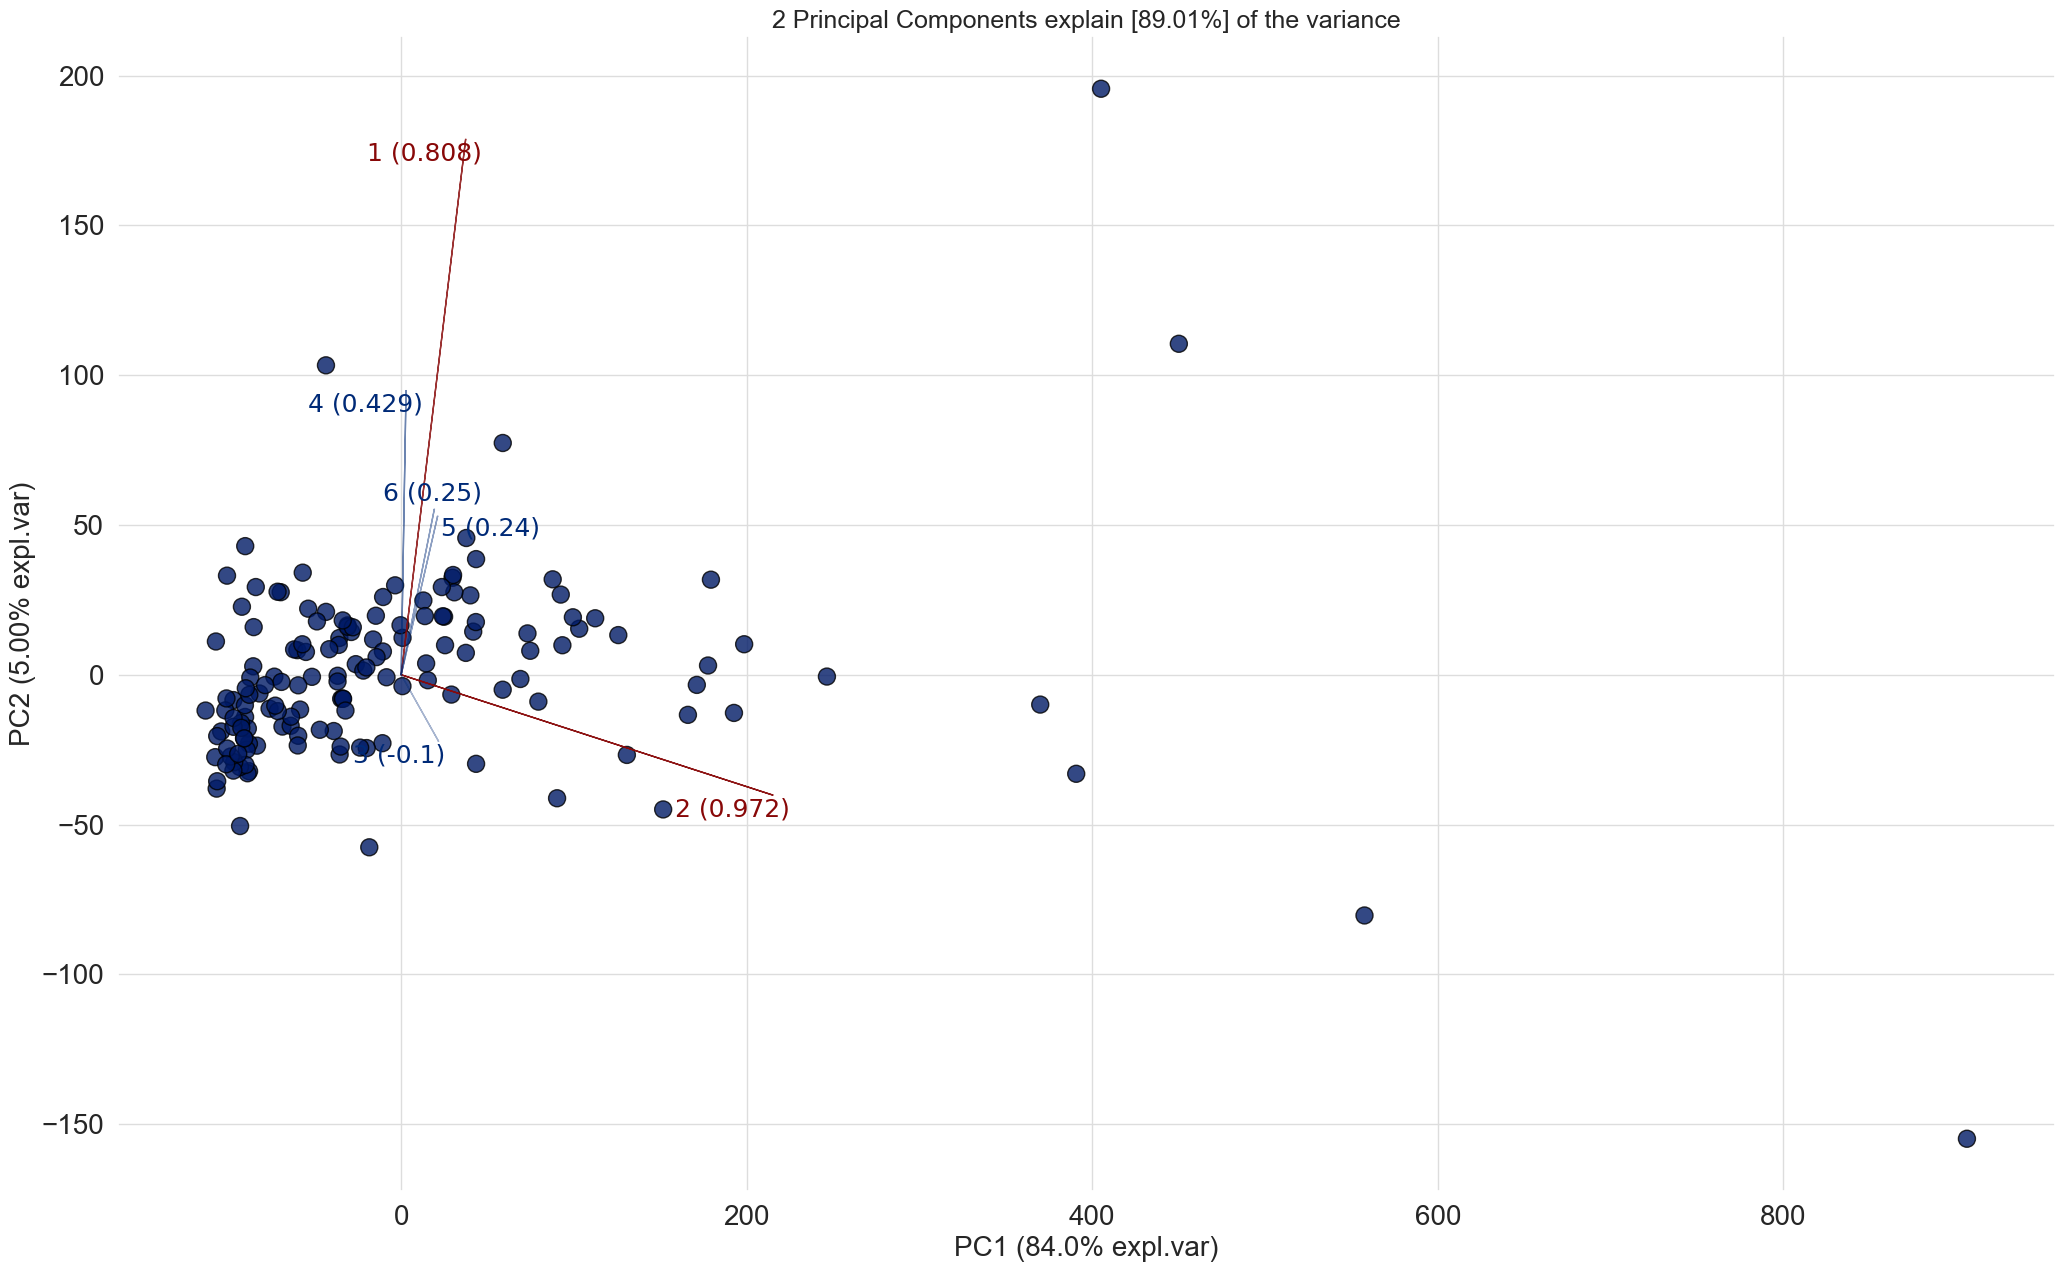

In [40]:
# pca biplot
new_pca.biplot()

The map/biplot is used to identify groups (clusters, if you will) of similar observations, but not as formally as in a clustering algorithm.

- Sometimes, interesting patterns can be revealed from the biplot. 
- Sometimes, there's not too much clustering

Notice on the second biplot that there are vectors plotted that represent the original x-features (2 is weight, and notice which point is furthest in the direction of weight?). 

Notice also that the second plot tells you how much variation is explained by each of the first two principal components (89% of the overall variation).

### Loading plot

In [45]:
result = new_pca.fit_transform(df_poke0.values)
result['loadings']
#result['PC']

[pca] >Cleaning previous fitted model results..
[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [6] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


,1,2,3,4,5,6
PC1,0.168641,0.972195,0.097896,0.012687,0.095472,0.086823
PC2,0.808024,-0.181519,-0.100449,0.429022,0.239637,0.250144


In [50]:
result['loadings'].T.PC1

1    0.168641
2    0.972195
3    0.097896
4    0.012687
5    0.095472
6    0.086823
Name: PC1, dtype: float64

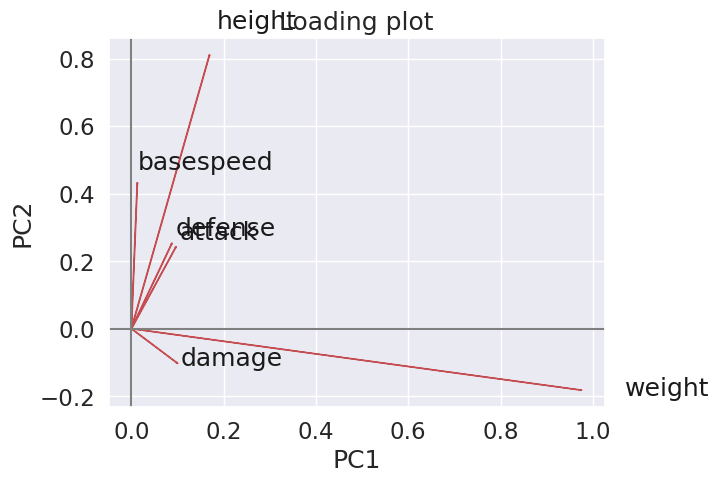

In [55]:
for i, feature in enumerate(df_poke0.columns):
    plt.arrow(0,0, result['loadings'].T.PC1[i], result['loadings'].T.PC2[i], color = 'r')
    plt.text(result['loadings'].T.PC1[i]*1.1, result['loadings'].T.PC2[i]*1.1, feature, 
             color = 'k')

plt.title('Loading plot')
plt.xlabel("PC1")
plt.ylabel('PC2')
plt.axhline(0, color = 'grey')
plt.axvline(0, color = 'grey')
plt.show()

## How many Principal Components to keep?

While the map/biplot gives us some understanding of how observations are related, the first goal of PCA is dimension reduction:
- You will end up with the same number of principal components as original x-features
- The principal components are sorted in order of "usefulness", or how much variation each explains
    - So, how many of the components should you keep?

In [57]:
pca = PCA(whiten = True)
x_new = pca.fit_transform(df_poke0.values)

In [63]:
pca.explained_variance_ratio_

array([0.84009084, 0.05009243, 0.03432512, 0.03163709, 0.03064586,
       0.01320866])

Text(0.5, 1.0, 'percentage of the variance explained by the PCA features')

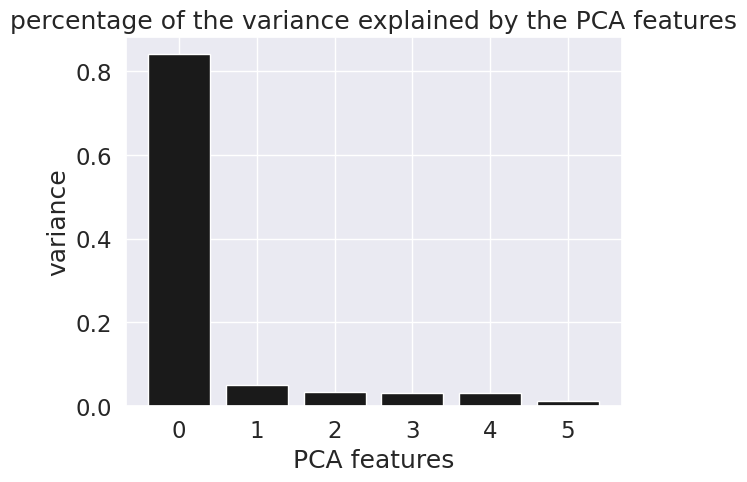

In [65]:
feature = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color = 'k')
plt.xlabel('PCA features')
plt.ylabel('variance')
plt.title('percentage of the variance explained by the PCA features')

## How many PCs to keep?

There are a few general strategies; here are two:
- (1): Use the bar plot (also called a "scree" plot) above, and choose the number of features up until the most obvious decrease in % variance explained (in this case, we would only need to keep the first PC)
- (2): Use a percentage benchmark; for example, an expert/client wishes you to make sure to keep at least 90% of the variation (in this case, you would need to keep the first three PCs, since we saw earlier that the first two sum to 89.01%)

In [66]:
pca.explained_variance_ratio_.cumsum()

array([0.84009084, 0.89018327, 0.92450839, 0.95614548, 0.98679134,
       1.        ])

# Lecture Break/Practice

Build a two dimensional PCA "map"/biplot of all the cars in the 'mpg' seaborn dataset. Then, determine how many PCs to keep.

Be sure to:
- use `x_feat_list = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']` as PCA inputs
- scatter via plotly so you can scroll over and examine the cars
- include `origin`,`model_year`, and `name` as `hover_data`
- make two scatter plots: 
    - one with coloring each sample according to the `model_year`
    - one with coloring each sample according to the `origin`
- make a bar plot with the variance explained to help you choose the number of PCs to keep

In [103]:
df_car = sns.load_dataset('mpg')
df_car.dropna(inplace=True)
df_car.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [104]:
x_feat_list = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']
df_car_x = df_car.loc[:, x_feat_list]

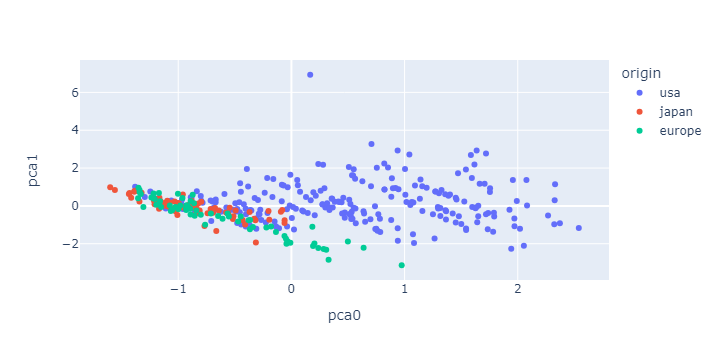

In [127]:
pca = PCA(whiten = True)
y = pca.fit_transform(df_car_x.values)

df_car['pca0'] = y[:,0]
df_car['pca1'] = y[:,1]

fig = px.scatter(df_car, x = 'pca0', y = 'pca1', hover_data = ['origin', 'name'], color = 'origin')
fig.show()

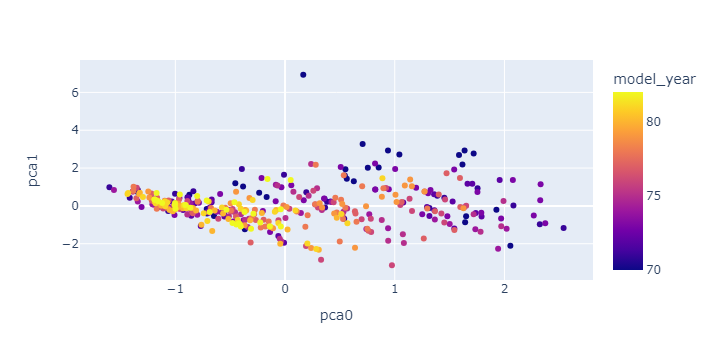

In [128]:

fig = px.scatter(df_car, x = 'pca0', y = 'pca1', hover_data = ['origin', 'name'], color = 'model_year')
fig.show()

Text(0, 0.5, 'variance')

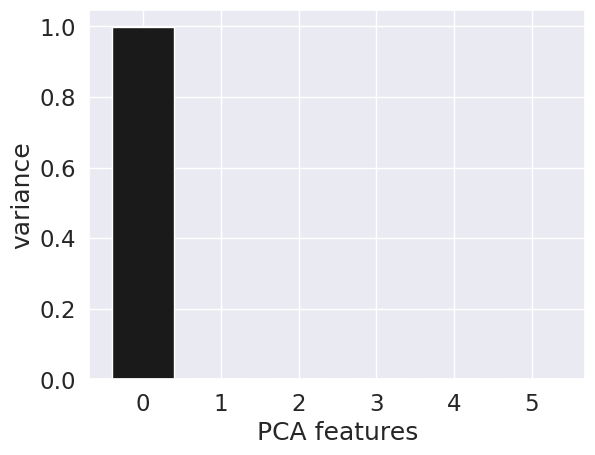

In [129]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color = 'k')
plt.xlabel('PCA features')
plt.ylabel('variance')

In [130]:
pca.explained_variance_ratio_.cumsum()

array([0.99755351, 0.99961561, 0.99997139, 0.99999567, 0.99999963,
       1.        ])

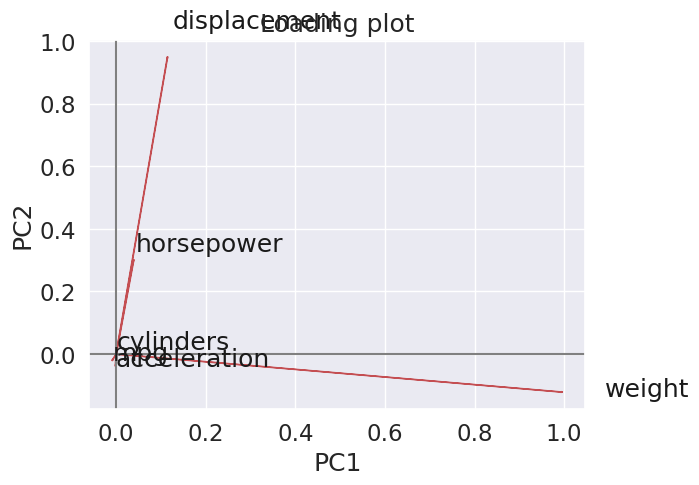

In [131]:
for i, feature in enumerate(df_car_x.columns):
    plt.arrow(0,0, pca.components_[0,i], pca.components_[1,i], color = 'r')
    plt.text(pca.components_[0,i]*1.1, pca.components_[1,i]*1.1, feature, 
             color = 'k')

plt.title('Loading plot')
plt.xlabel("PC1")
plt.ylabel('PC2')
plt.axhline(0, color = 'grey')
plt.axvline(0, color = 'grey')
plt.show()

# More examples

For the next part, you will load a picture called `pet.jpeg`. We first convert it into an array with dimension 900*900*3. Our goal will be to conduct PCA using this images to compress them, storing the images based on principal components. The cells below read in the image, convert it into an array, and then plot it. 

In [76]:
from PIL import Image
import numpy as np
 
# read an image
img = Image.open('pet.jpg')

In [81]:
pet_data = np.asarray(img)
pet_data.shape

(900, 900, 3)

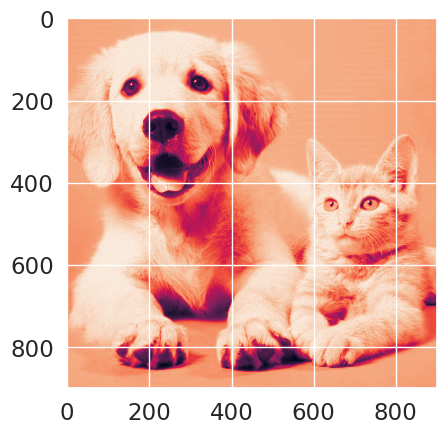

In [82]:
plt.imshow(pet_data[:,:,0])

In [83]:
pca = PCA()

petImg_data_compress = pca.fit_transform(pet_data[:,:, 0])

In [88]:
bench0 = np.argmax(pca.explained_variance_ratio_.cumsum() > 0.6)
bench1 = np.argmax(pca.explained_variance_ratio_.cumsum() > 0.75)
bench2 = np.argmax(pca.explained_variance_ratio_.cumsum() > 0.95)

In [89]:
print(bench0)
print(bench1)
print(bench2)

2
4
22


In [98]:
pca = PCA(n_components = bench2+1)
x_pca = pca.fit_transform(pet_data[:,:,0])
x_pred = pca.inverse_transform(x_pca)
x_pred.shape

(900, 900)

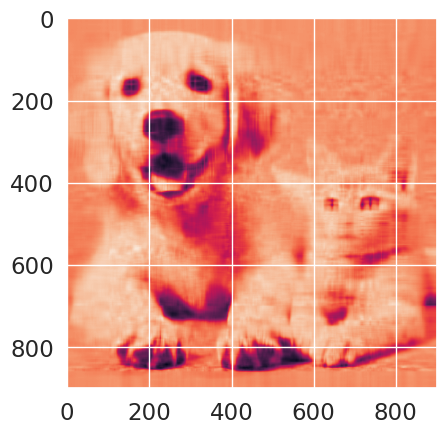

In [99]:
plt.imshow(x_pred)